# Analysing Wall Street Bets 
---
Below we look at the number of times a stock in mentioned on wall street bets.

### Imports 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import sqlalchemy
import psycopg2
import psycopg2.extras
import datetime

import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

import pandas.io.sql as sqlio

sys.path.append("../")
import config

### Connect to DataBase

In [3]:
connection = psycopg2.connect(host=config.DB_HOST, database=config.DB_NAME, user=config.DB_USER, password=config.DB_PASS)

sql_stock = "SELECT * FROM stock"
sql_mention = "SELECT * FROM mention"

In [4]:
stocks = sqlio.read_sql_query(sql_stock, connection)
mention_df = sqlio.read_sql_query(sql_mention, connection)

In [5]:
stocks = stocks[stocks.symbol.str.len() > 2]

In [6]:
mention_df.head(1)

,stock_id,dt,message,source,url
0,6541,2021-02-14 18:24:08,Unilever $UL - Why this oversold boomer stock ...,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...


### Mentions Analysis

In [7]:
print("The dataset starts at {} and ends at {}".format(mention_df.dt.min(), mention_df.dt.max()))
print("The Total number of mentions we see: {}".format(mention_df.shape[0]))
print("The Total number of stocks mentioned: {}".format(mention_df.stock_id.nunique()))

The dataset starts at 2021-02-07 23:23:20 and ends at 2021-02-18 12:44:10
The Total number of mentions we see: 7181
The Total number of stocks mentioned: 755


In [8]:
stocks.head(1)

,id,symbol,name,country,sector,industry,exchange
0,1,AACG,ATA Creativity Global American Depositary Shares,China,Consumer Services,Other Consumer Services,NASDAQ


In [9]:
print('stocks shape: {}'.format(stocks.shape))
print('mentions shape: {}'.format(mention_df.shape))

stocks shape: (7026, 7)
mentions shape: (7181, 5)


In [10]:
df = pd.merge(mention_df, stocks, how='left', left_on='stock_id', right_on='id')

In [11]:
aggs = df.symbol.value_counts().to_frame()

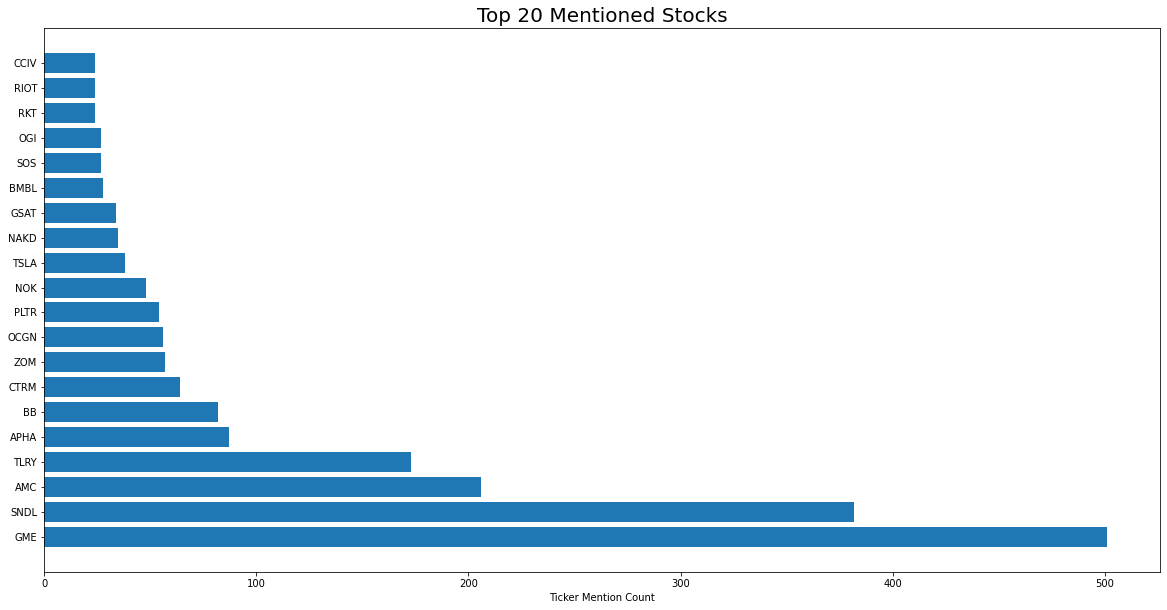

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(aggs.iloc[:20].index, aggs.iloc[:20].symbol)
ax.set_xlabel('Ticker Mention Count')
ax.set_title('Top 20 Mentioned Stocks', size=20)
plt.show()

In [13]:
df['date'] = df['dt'].dt.date

In [14]:
aggregation_df = df.groupby(['date', 'symbol']).agg({'message': 'count'}).rename(columns={'message': 'mention_count'})

In [15]:
brush = alt.selection_interval()

In [16]:
aggregation_df = aggregation_df.reset_index()

aggregation_df.sort_values(by='date', inplace=True)

aggregation_df['date']= pd.to_datetime(aggregation_df['date'])

# Total Number of Mentions over time

In [17]:
def plot_mentions_over_time(df):
    brush = alt.selection_interval()

    mention_chart = alt.Chart(df).mark_line(point=True).encode(
                alt.X('date:T', ),
                alt.Y('mention_count:Q'),
                alt.Color('symbol:N')
    ).properties(
                width=800,
                height=400,
    ).add_selection(
                brush,

    )

    aggregation = alt.Chart(df).mark_rect().encode(
                alt.X('sum(mention_count):Q', sort='ascending'),
                alt.Y('symbol:N'),
                alt.Color('symbol:N')
    ).properties(
                width=800,
                height=200,
    ).transform_filter(
                brush
            )

    return mention_chart & aggregation

In [18]:
plot_mentions_over_time(aggregation_df[aggregation_df.symbol.isin(list(aggs.index[:10]))])

alt.VConcatChart(...)

### Add mention percent changes

In [19]:
ticker_list = list(aggregation_df.symbol.unique())

for ticker in ticker_list:
    
    # Daily percent change 
    aggregation_df.loc[aggregation_df.symbol == ticker, 'daily_pct_change'] = \
    aggregation_df.mention_count[aggregation_df.symbol == ticker].pct_change() * 100
    
    # 3 day percent change
    aggregation_df.loc[aggregation_df.symbol == ticker, 'three_day_pct_change'] = \
    aggregation_df.mention_count[aggregation_df.symbol == ticker].pct_change(3) * 100
    
    # weekly percent change
    aggregation_df.loc[aggregation_df.symbol == ticker, 'weekly_pct_change'] = \
    aggregation_df.mention_count[aggregation_df.symbol == ticker].pct_change(7 ) * 100

## Recently Trending Stocks

#### One Day Mention Growth Stocks

In [20]:
trending_df = aggregation_df[(aggregation_df.date == aggregation_df.date.max()) & 
              (aggregation_df.daily_pct_change > 0)].sort_values(by='mention_count', ascending=False)

In [21]:
trending_df

,date,symbol,mention_count,daily_pct_change,three_day_pct_change,weekly_pct_change
1382,2021-02-18,GME,20,81.818182,5.263158,-71.014493
1393,2021-02-18,PLTR,6,50.000000,500.000000,500.000000
1394,2021-02-18,PLUG,3,200.000000,0.000000,NaN
1390,2021-02-18,OCGN,2,100.000000,100.000000,-83.333333
1403,2021-02-18,TRCH,2,100.000000,-33.333333,NaN
1368,2021-02-18,APHA,2,100.000000,-33.333333,0.000000


In [22]:
plot_mentions_over_time(aggregation_df[aggregation_df.symbol.isin(list(trending_df.symbol))])

alt.VConcatChart(...)

#### Three Day Mention Growth Stocks

In [23]:
trending_df = aggregation_df[(aggregation_df.date == aggregation_df.date.max()) & 
              (aggregation_df.three_day_pct_change > 0)].sort_values(by='mention_count', ascending=False)

In [24]:
trending_df

,date,symbol,mention_count,daily_pct_change,three_day_pct_change,weekly_pct_change
1382,2021-02-18,GME,20,81.818182,5.263158,-71.014493
1393,2021-02-18,PLTR,6,50.000000,500.000000,500.000000
1390,2021-02-18,OCGN,2,100.000000,100.000000,-83.333333
1379,2021-02-18,EH,2,0.000000,100.000000,NaN


In [25]:
plot_mentions_over_time(aggregation_df[aggregation_df.symbol.isin(list(trending_df.symbol))])

alt.VConcatChart(...)